# Activity of the hiden layer, characterisation

In [3]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set(font_scale=3.0)

In [4]:
from network import MinaNetwork

#### An example of activity calculation

In [109]:
N_input = 20  # Inputs size
N_recurrent = 20  # C3 size
v = 25.0   # Input - C3 connection
b = 25.0   # Input - C1 connection
Kr = 0.8   # Recurrent self-inhibition gain
Ki = 1.0  # Input - C3 inhibition
Ci = 1.0  # Inhibition from the input to C1
Cr = 1.0  # Inhibition from C3 to C1
p = 1.0   # Sparness parameter

# Dynamical parameters
theta = 0.0
phi = 0

# Patterns
number_of_patterns = 10
sparsity = 10.0


nn = MinaNetwork(n_input=N_input, n_recurrent=N_recurrent, p=p, v=v, b=b, Ki=Ki, Kr=Kr, Ci=Ci, Cr=Cr,
                 theta=theta, phi=phi, uniform_w=True)

nn.build_patterns_dictionary(sparsity=sparsity, number_of_patterns=number_of_patterns)

In [110]:
sequence = [0, 1, 2, 3, 4]
training_time = 100
epsilon = 0.1

quantities = nn.train_network(epsilon=epsilon, training_time=training_time, pre_synaptic_rule=True,
                              sequence=sequence, verbose=False, save_quantities=True)

z_r_end = np.mean(quantities['z_r'], axis=0)
print(z_r_end)


[ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.   0.   0.   0.   0.
  0.   0.   0.   0.   0. ]


In [111]:
explicit_nn_length = nn.neurons_per_pattern * (sequence[-1] + 1)
print('non hidden length', explicit_nn_length)

non hidden length 10


In [112]:
z_hidden = z_r_end[explicit_nn_length:]

Now I need to test for recall. How?

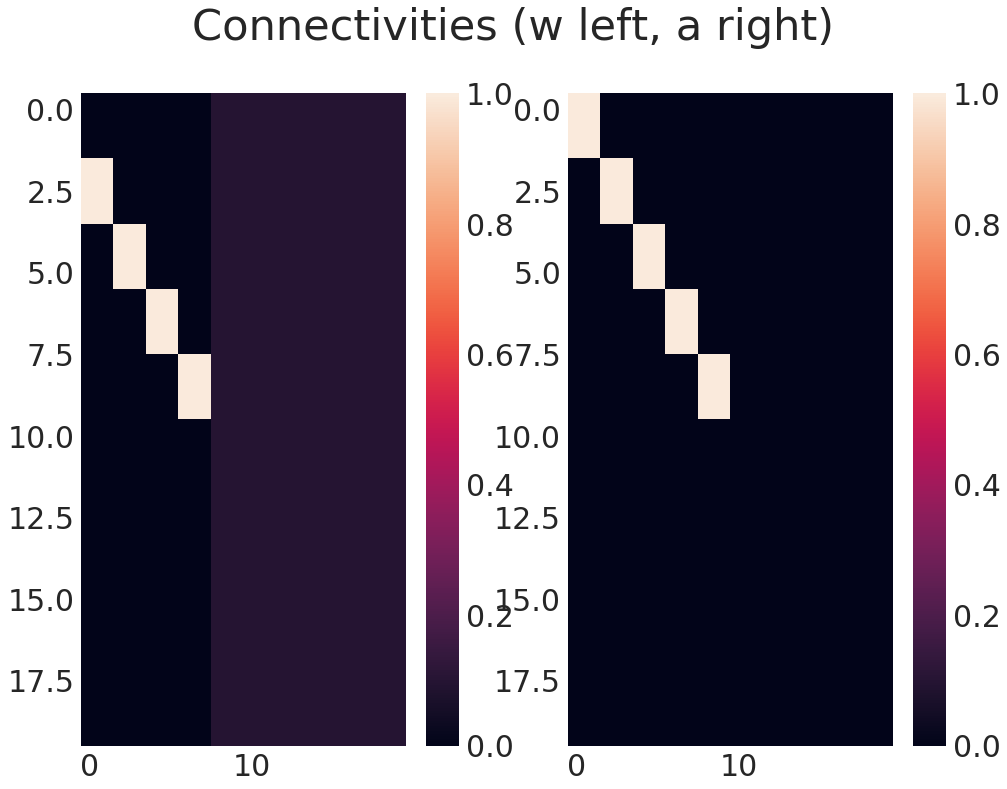

In [113]:
fig = plt.figure(figsize=(16, 12))

fig.suptitle('Connectivities (w left, a right)')

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(nn.w, aspect='auto', vmin=0, vmax=1)
ax1.grid()

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(nn.a, aspect='auto', vmin=0, vmax=1)
ax2.grid()

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2);

In [123]:
cue = sequence[0]
recall_time = len(sequence)
z_recall = nn.recall(recall_time=recall_time, cue=cue, verbose=False)

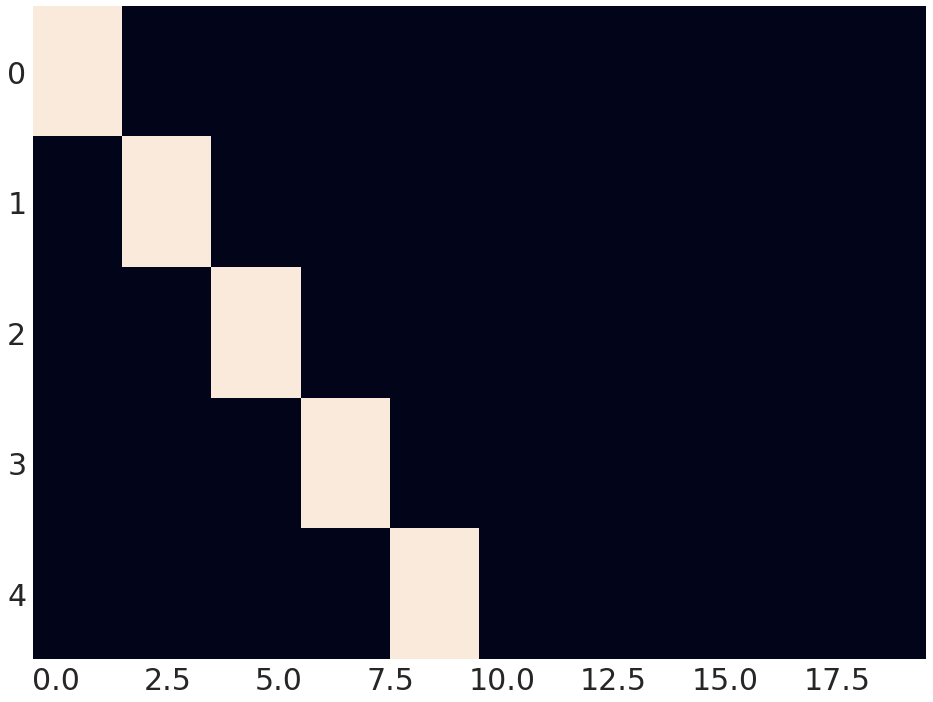

In [124]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.grid()
im = ax.imshow(z_recall, aspect='auto');

In [119]:
x = nn.patterns_dictionary[3]
y = z_recall[3]

print(x)
print(y)
np.allclose(x, y)

[ 0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
[ 0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


True

In [121]:
for sequence_number, z in zip(sequence, z_recall):
    success = True
    x = nn.patterns_dictionary[sequence_number]
    if not np.allclose(x, z):
        success = False
        break 

In [122]:
success

True

In [130]:
def test_recall_bolean(nn, sequence):
    # Recall
    cue = sequence[0]
    recall_time = len(sequence)
    z_recall = nn.recall(recall_time=recall_time, cue=cue, verbose=False)
    
    # Test equality
    success = True
    for sequence_number, z in zip(sequence, z_recall):
        x = nn.patterns_dictionary[sequence_number]
        if not np.allclose(x, z):
            success = False
            break 
    
    return success

In [131]:
test_recall_bolean(nn, sequence=sequence)

True

In [133]:
def test_recall(nn, sequence):
    # Recall
    cue = sequence[0]
    recall_time = len(sequence)
    z_recall = nn.recall(recall_time=recall_time, cue=cue, verbose=False)
    
    # Test equality
    success = 0.0
    for sequence_number, z in zip(sequence, z_recall):
        x = nn.patterns_dictionary[sequence_number]
        if np.allclose(x, z):
            success += 1.0 
    
    success /= recall_time
    return success * 100.0

In [134]:
test_recall(nn, sequence)

100.0

## Dependence on recurrence

In [135]:
N_input = 20  # Inputs size
N_recurrent = 20  # C3 size
v = 25.0   # Input - C3 connection
b = 25.0   # Input - C1 connection
Kr = 0.8   # Recurrent self-inhibition gain
Ki = 1.0  # Input - C3 inhibition
Ci = 1.0  # Inhibition from the input to C1
Cr = 1.0  # Inhibition from C3 to C1
p = 1.0   # Sparness parameter

# Dynamical parameters
theta = 0.0
phi = 0

# Training patterns
number_of_patterns = 10
sparsity = 10.0

sequence = [0, 1, 2, 3, 4]
training_time = 500
epsilon = 0.1

In [147]:
Kr_vector = np.arange(0.1, 1.1, 0.05)
z_vector = []
mean_hidden_activity = []
std_hidden_activity = []
mean_activity = []
std_activity = []
success_history = []

for Kr in Kr_vector:
    nn = MinaNetwork(n_input=N_input, n_recurrent=N_recurrent, p=p, v=v, b=b, Ki=Ki, Kr=Kr, Ci=Ci, Cr=Cr,
                 theta=theta, phi=phi, uniform_w=False)

    nn.build_patterns_dictionary(sparsity=sparsity, number_of_patterns=number_of_patterns)
    quantities = nn.train_network(epsilon=epsilon, training_time=training_time, pre_synaptic_rule=True,
                              sequence=sequence, verbose=False, save_quantities=True)

    z_r_end = np.mean(quantities['z_r'], axis=0)
    explicit_nn_length = nn.neurons_per_pattern * (sequence[-1] + 1)
    z_r_non_hidden = z_r_end[:explicit_nn_length]
    z_hidden = z_r_end[explicit_nn_length:]
    
    success = test_recall(nn, sequence)
    
    # Store
    z_vector.append(np.copy(z_r_end))
    mean_hidden_activity.append(np.mean(z_hidden))
    std_hidden_activity.append(np.std(z_hidden))
    mean_activity.append(np.mean(z_r_non_hidden))
    std_activity.append(np.std(z_r_non_hidden))    
    success_history.append(success * 1.0 / 100.0)
    
z_matrix = np.array(z_vector)

#### Let's plot some quantities

In [148]:
z_matrix.shape

(20, 20)

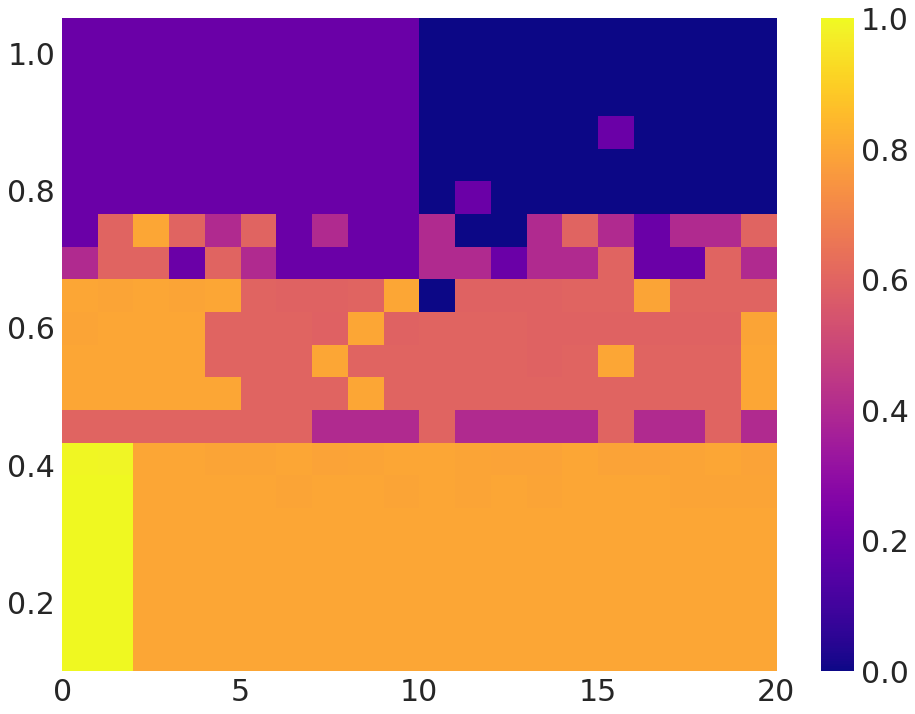

In [149]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.grid()

extent = [0, N_recurrent, Kr_vector[0], Kr_vector[-1]]

im = ax.imshow(z_vector, aspect='auto', extent=extent, origin='lower', cmap='plasma')

fig.colorbar(im, ax=ax);

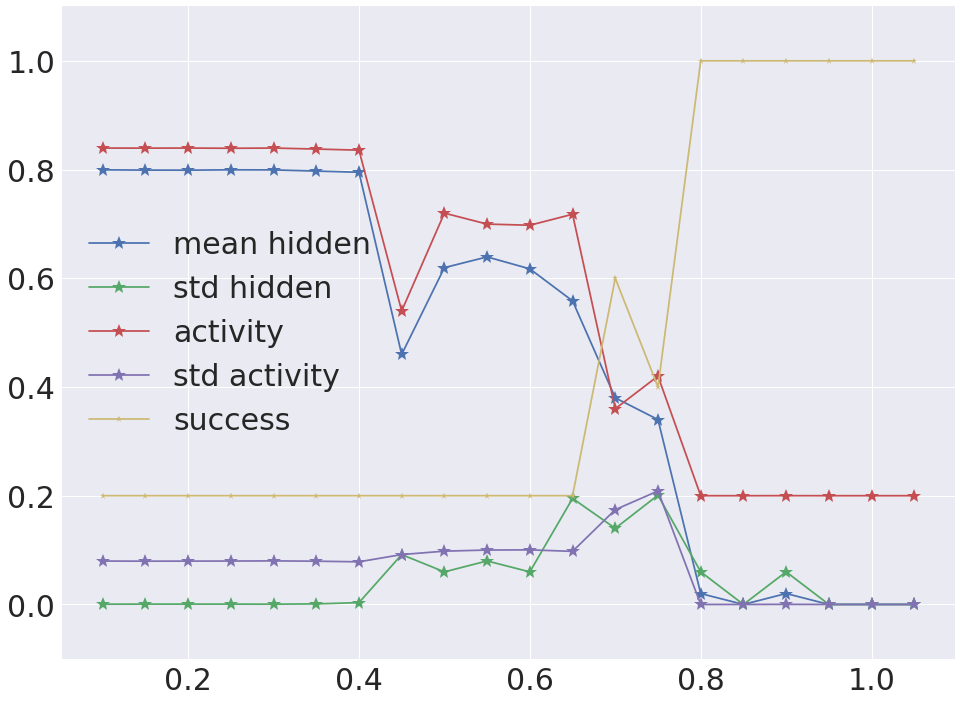

In [150]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ln = ax.plot(Kr_vector, mean_hidden_activity, '*-', markersize=15, label='mean hidden')
ln = ax.plot(Kr_vector, std_hidden_activity, '*-', markersize=15, label='std hidden')

ln = ax.plot(Kr_vector, mean_activity, '*-', markersize=15, label='activity')
ln = ax.plot(Kr_vector, std_activity, '*-', markersize=15, label='std activity')

ln = ax.plot(Kr_vector, success_history, '*-', label='success')

ax.set_ylim([-0.1, 1.1])
ax.legend();

Let's take a finner look at the area between 0.5 and 0.8

In [151]:
N_input = 20  # Inputs size
N_recurrent = 20  # C3 size
v = 25.0   # Input - C3 connection
b = 25.0   # Input - C1 connection
Kr = 0.8   # Recurrent self-inhibition gain
Ki = 1.0  # Input - C3 inhibition
Ci = 1.0  # Inhibition from the input to C1
Cr = 1.0  # Inhibition from C3 to C1
p = 1.0   # Sparness parameter

# Dynamical parameters
theta = 0.0
phi = 0

# Training patterns
number_of_patterns = 10
sparsity = 10.0

sequence = [0, 1, 2, 3, 4]
training_time = 500
epsilon = 0.1

In [152]:
Kr_vector = np.arange(0.35, 0.86, 0.01)
z_vector = []
mean_hidden_activity = []
std_hidden_activity = []
mean_activity = []
std_activity = []
success_history = []


for Kr in Kr_vector:
    nn = MinaNetwork(n_input=N_input, n_recurrent=N_recurrent, p=p, v=v, b=b, Ki=Ki, Kr=Kr, Ci=Ci, Cr=Cr,
                 theta=theta, phi=phi, uniform_w=False)

    nn.build_patterns_dictionary(sparsity=sparsity, number_of_patterns=number_of_patterns)
    quantities = nn.train_network(epsilon=epsilon, training_time=training_time, pre_synaptic_rule=True,
                              sequence=sequence, verbose=False, save_quantities=True)

    z_r_end = np.mean(quantities['z_r'], axis=0)
    explicit_nn_length = nn.neurons_per_pattern * (sequence[-1] + 1)
    z_r_non_hidden = z_r_end[:explicit_nn_length]
    z_hidden = z_r_end[explicit_nn_length:]
    
    success = test_recall(nn, sequence)
    
    # Store
    z_vector.append(np.copy(z_r_end))
    mean_hidden_activity.append(np.mean(z_hidden))
    std_hidden_activity.append(np.std(z_hidden))
    mean_activity.append(np.mean(z_r_non_hidden))
    std_activity.append(np.std(z_r_non_hidden))    
    success_history.append(success * 1.0 / 100.0)
    
z_matrix = np.array(z_vector)

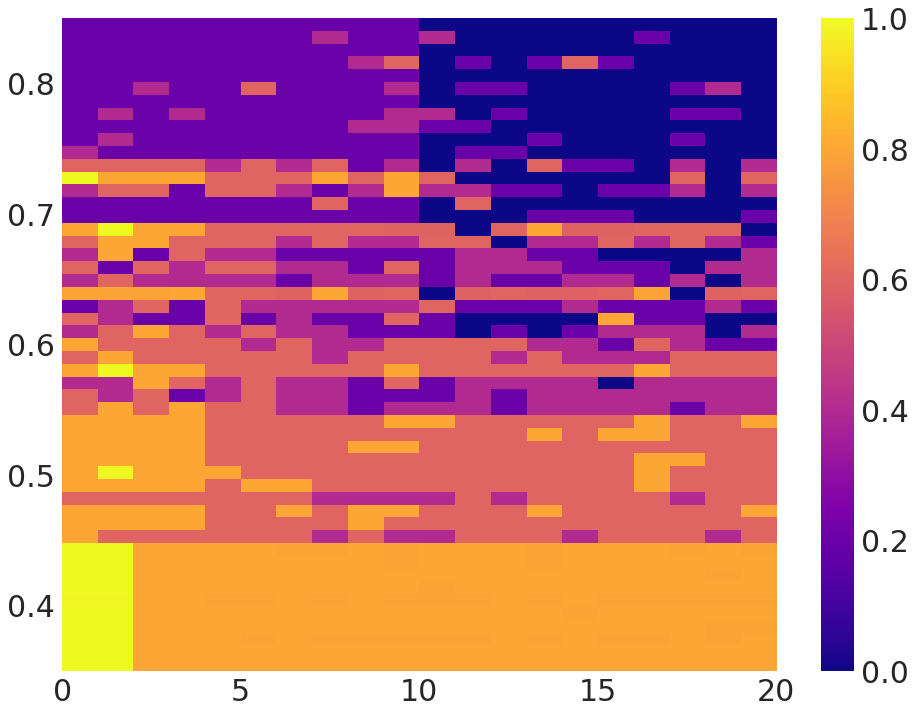

In [153]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.grid()

extent = [0, N_recurrent, Kr_vector[0], Kr_vector[-1]]

im = ax.imshow(z_vector, aspect='auto', extent=extent, origin='lower', cmap='plasma')

fig.colorbar(im, ax=ax);

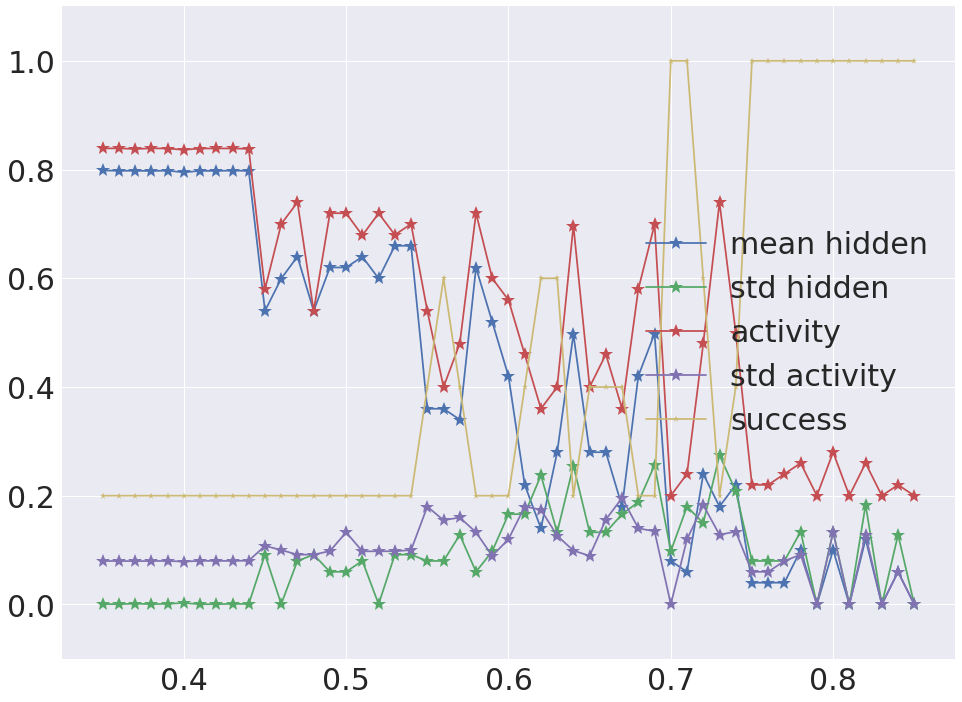

In [155]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ln = ax.plot(Kr_vector, mean_hidden_activity, '*-', markersize=15, label='mean hidden')
ln = ax.plot(Kr_vector, std_hidden_activity, '*-', markersize=15, label='std hidden')

ln = ax.plot(Kr_vector, mean_activity, '*-', markersize=15, label='activity')
ln = ax.plot(Kr_vector, std_activity, '*-', markersize=15, label='std activity')

ln = ax.plot(Kr_vector, success_history, '*-', label='success')

ax.set_ylim([-0.1, 1.1])
ax.legend();

## Eliminating the input inhibitory feedback

In [13]:
N_input = 20  # Inputs size
N_recurrent = 20  # C3 size
v = 25.0   # Input - C3 connection
b = 25.0   # Input - C1 connection
Kr = 0.8   # Recurrent self-inhibition gain
Ki = 0.0  # Input - C3 inhibition
Ci = 1.0  # Inhibition from the input to C1
Cr = 1.0  # Inhibition from C3 to C1
p = 1.0   # Sparness parameter

# Dynamical parameters
theta = 0.0
phi = 0

# Training patterns
number_of_patterns = 10
sparsity = 10.0

sequence = [0, 1, 2, 3, 4]
training_time = 500
epsilon = 0.1

In [14]:
Kr_vector = np.arange(0.1, 2.5, 0.05)
z_vector = []
mean_hidden_activity = []
std_hidden_activity = []
mean_activity = []
std_activity = []
success_history = []

for Kr in Kr_vector:
    nn = MinaNetwork(n_input=N_input, n_recurrent=N_recurrent, p=p, v=v, b=b, Ki=Ki, Kr=Kr, Ci=Ci, Cr=Cr,
                 theta=theta, phi=phi, uniform_w=False)

    nn.build_patterns_dictionary(sparsity=sparsity, number_of_patterns=number_of_patterns)
    quantities = nn.train_network(epsilon=epsilon, training_time=training_time, pre_synaptic_rule=True,
                              sequence=sequence, verbose=False, save_quantities=True)

    z_r_end = np.mean(quantities['z_r'], axis=0)
    explicit_nn_length = nn.neurons_per_pattern * (sequence[-1] + 1)
    z_r_non_hidden = z_r_end[:explicit_nn_length]
    z_hidden = z_r_end[explicit_nn_length:]
    
    success = nn.test_recall(sequence)
    
    # Store
    z_vector.append(np.copy(z_r_end))
    mean_hidden_activity.append(np.mean(z_hidden))
    std_hidden_activity.append(np.std(z_hidden))
    mean_activity.append(np.mean(z_r_non_hidden))
    std_activity.append(np.std(z_r_non_hidden))    
    success_history.append(success * 1.0 / 100.0)
    
z_matrix = np.array(z_vector)

#### Let's plot some quantities

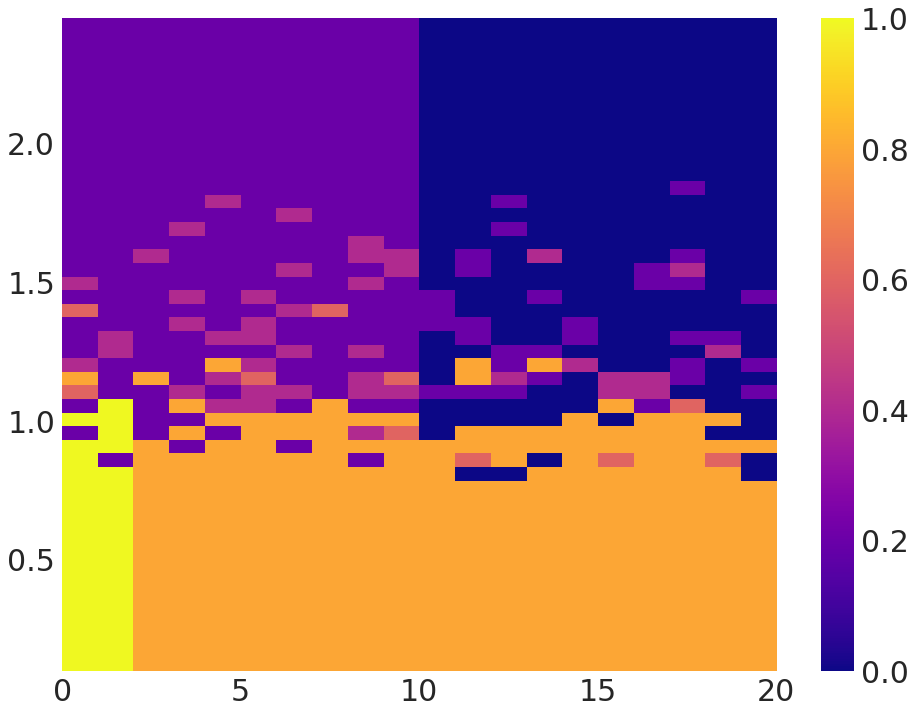

In [15]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.grid()

extent = [0, N_recurrent, Kr_vector[0], Kr_vector[-1]]

im = ax.imshow(z_vector, aspect='auto', extent=extent, origin='lower', cmap='plasma')

fig.colorbar(im, ax=ax);

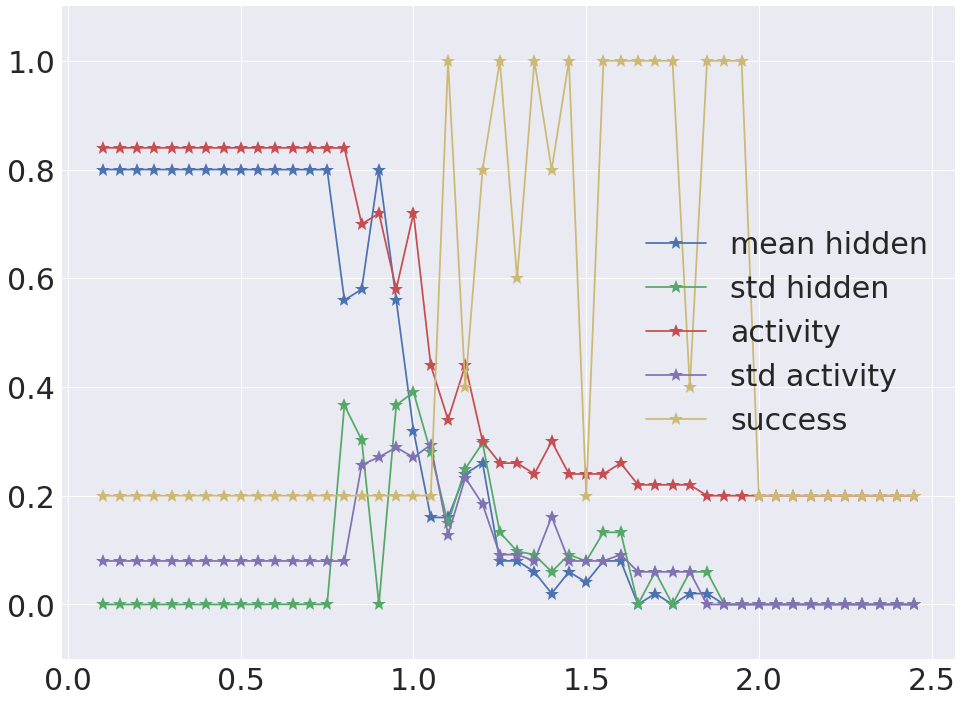

In [16]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ln = ax.plot(Kr_vector, mean_hidden_activity, '*-', markersize=15, label='mean hidden')
ln = ax.plot(Kr_vector, std_hidden_activity, '*-', markersize=15, label='std hidden')

ln = ax.plot(Kr_vector, mean_activity, '*-', markersize=15, label='activity')
ln = ax.plot(Kr_vector, std_activity, '*-', markersize=15, label='std activity')

ln = ax.plot(Kr_vector, success_history, '*-', markersize=15, label='success')

ax.set_ylim([-0.1, 1.1])
ax.legend();